In [632]:
import lenskit.datasets as ds
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import re


%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

In [633]:
#creating data frames for csv

mov_df = pd.read_csv('data/movies.csv')
rat_df = pd.read_csv('data/ratings.csv')
tag_df = pd.read_csv('data/tags.csv')
lin_df = pd.read_csv('data/links.csv')

In [634]:
#peek at the data
mov_df.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [635]:
rat_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [636]:
tag_df

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


#### Joining data files and preprocessing in generic recommendation
The dataset we are using have been 'lightly' preprocessed by filling the missing data (such as reviews) with 0, for creating a generic recommendation all we need to do is join the data files so that informations from ratings and movies match. 

Later on when we create a new dataframe for advanced recommendations where each column represents unique user and rows represents each unique movie we will need to addres the problem of missing data (for movies which the user haven't rated), data sparsity and noise.

In [637]:

joined_data = rat_df.join(mov_df.set_index('movieId')['genres'], on='movieId')
joined_data = joined_data.join(mov_df.set_index('movieId')['title'], on='movieId')

joined_data.head()

,userId,movieId,rating,timestamp,genres,title
0,1,1,4.0,964982703,Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995)
1,1,3,4.0,964981247,Comedy|Romance,Grumpier Old Men (1995)
2,1,6,4.0,964982224,Action|Crime|Thriller,Heat (1995)
3,1,47,5.0,964983815,Mystery|Thriller,Seven (a.k.a. Se7en) (1995)
4,1,50,5.0,964982931,Crime|Mystery|Thriller,"Usual Suspects, The (1995)"


### Generic recommendation
First we will create a generic movie recommendation set will be created by filtering the data set by the amount of users who rated it.

In [638]:
user_filter = 100 #how many users rated movie

rat_amount = rat_df.groupby(['movieId']).count()
rat_mean = rat_df.groupby(['movieId']).mean()
rat_avg = rat_mean.loc[rat_amount['rating'] > user_filter]

sorted_rat_avg = rat_avg.sort_values(by="rating", inplace=False, ascending=False)

joined_data = sorted_rat_avg.join(mov_df.set_index('movieId')['genres'], on='movieId')
joined_data = joined_data.join(mov_df.set_index('movieId')['title'], on='movieId')
joined_data = joined_data[joined_data.columns[3:]]

print("recommended movies by highest rated:")
joined_data.head(10)

recommended movies by highest rated:


,genres,title
movieId,,
318,Crime|Drama,"Shawshank Redemption, The (1994)"
858,Crime|Drama,"Godfather, The (1972)"
2959,Action|Crime|Drama|Thriller,Fight Club (1999)
1221,Crime|Drama,"Godfather: Part II, The (1974)"
48516,Crime|Drama|Thriller,"Departed, The (2006)"
1213,Crime|Drama,Goodfellas (1990)
58559,Action|Crime|Drama|IMAX,"Dark Knight, The (2008)"
50,Crime|Mystery|Thriller,"Usual Suspects, The (1995)"
1197,Action|Adventure|Comedy|Fantasy|Romance,"Princess Bride, The (1987)"


#### Analysis of users and movies
Before creating personalized recommendations we can take a look at the movie genres and the userbase

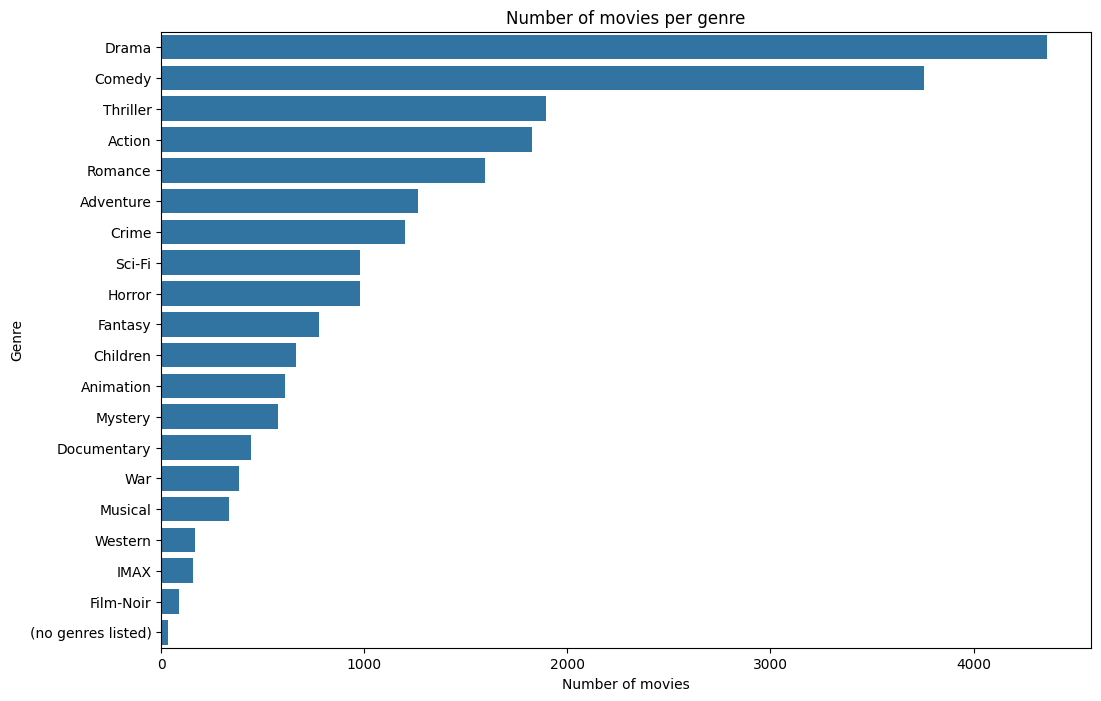

In [639]:
genre_counts = mov_df['genres'].str.split('|', expand=True).stack().value_counts()

plt.title('Number of movies per genre')
plt.xlabel('Number of movies')
plt.ylabel('Genre')
sns.barplot(x = genre_counts.values, y = genre_counts.index)
plt.show()

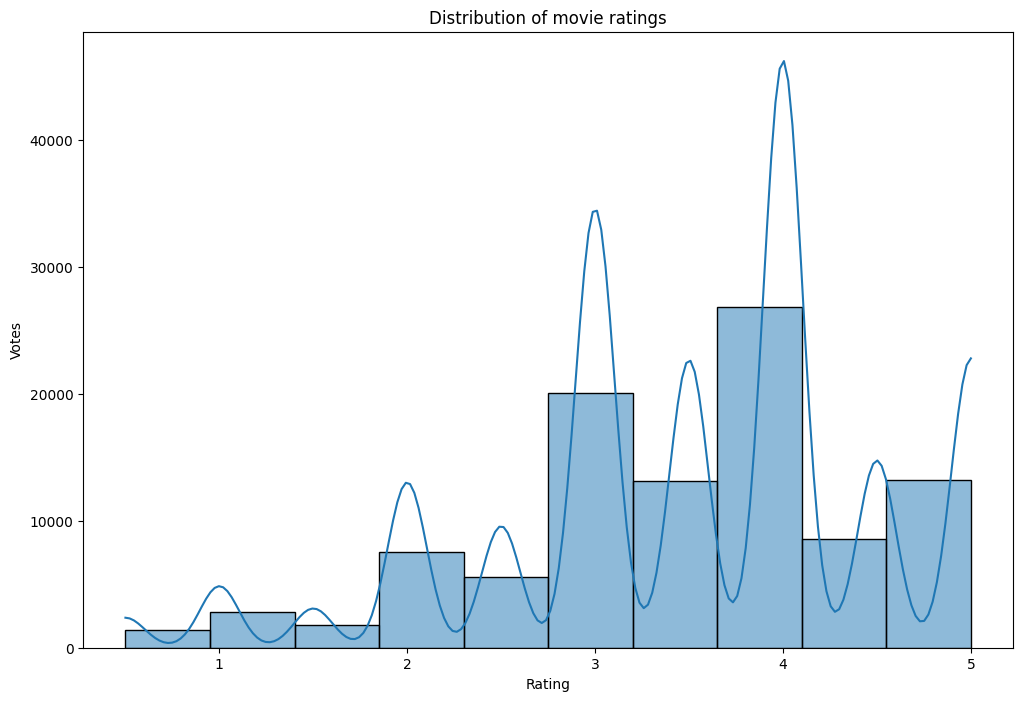

In [640]:
plt.title('Distribution of movie ratings')
plt.xlabel('Rating')
plt.ylabel('Votes')
sns.histplot(rat_df['rating'], bins=10, kde=True)
plt.show()

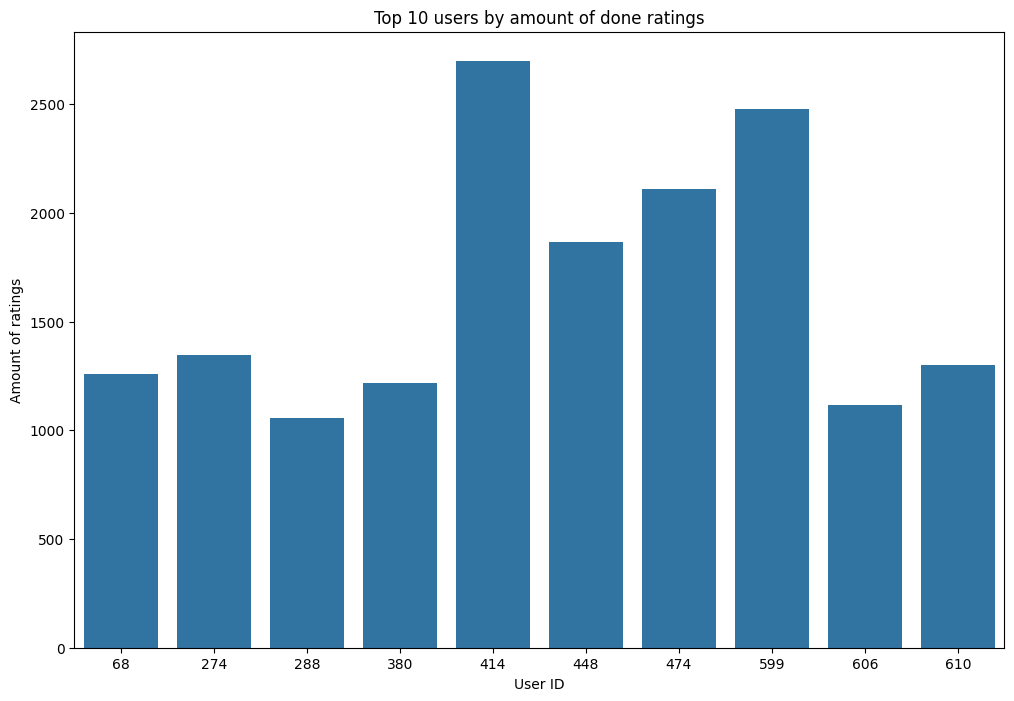

In [641]:
#checking users with highest ammount of rated movies
top_users = rat_df['userId'].value_counts().head(10)

plt.title('Top 10 users by amount of done ratings')
plt.xlabel('User ID')
plt.ylabel('Amount of ratings')
sns.barplot(x=top_users.index, y=top_users.values)
plt.show()

### Advanced recommenders

#### Data preprocessing
As mentioned at the start we will need to create a new dataframe for movie rating, where each column represents unique users and each row represents unique movie.

Besides filling the missing data, we will need to remove noise from data, meaning getting rid of users with small amount of rated movies, and movies rated by few users.

In [642]:
users_movs = rat_df.pivot(index='movieId', columns='userId' , values='rating')
#filling missing rating data with 0
users_movs.fillna(0,inplace=True)

#removing noise
user_votes = rat_df.groupby('movieId')['rating'].agg('count')
movies_votes = rat_df.groupby('userId')['rating'].agg('count')

users_movs = users_movs.loc[user_votes[user_votes > 10].index,:] #removing movies with voted by less than 10 users
users_movs=users_movs.loc[:,movies_votes[movies_votes > 50].index] #removing users who voted for less than 50 movies

users_movs


userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Most of the values in users_movs are sparse, we need to reduce the sparsity if we are to fed it to the dataset with large amount of features. To do this we can use csr_matrix from scipy library which is used for sparsity reducing

In [643]:
#Reduce sparsity
sample = np.array([[0,0,3,0,0],[4,0,0,0,2],[0,0,0,0,1]])
sparsity = 1.0 - ( np.count_nonzero(sample) / float(sample.size) )

csr_sample = csr_matrix(sample)

csr_data = csr_matrix(users_movs.values)
users_movs.reset_index(inplace=True)

#### Personalized recommender
Function for making a personalized movie recommendations for one of the users form database

In [644]:
def userdf_recoms(user_id, genre, recom_movies):
    similar = cosine_similarity(users_movs)
    
    #finding most similar user to currently compared
    user_index = users_movs.index.get_loc(user_id)


    similar_users = similar[user_index]
    similar_users_index = np.argsort(-similar_users)[1:] #argsort to get users indexes (descending order )
    
    similar_users_id = users_movs.index[similar_users_index]
    similar_users_rats = users_movs.loc[similar_users_id]


    rats_mean = similar_users_rats.mean(axis=0) 
    user_rat_movs = users_movs.loc[user_id].dropna().index
    rats_mean = rats_mean.drop(user_rat_movs, errors='ignore')
    
    if genre:
        genre_movs = mov_df[mov_df['genres'].str.contains(genre, case=False, na=False)]
        rats_mean = rats_mean[rats_mean.index.isin(genre_movs['movieId'])] 
    
    top_recoms = rats_mean.sort_values(ascending=False).head(recom_movies)
    
    final_recoms = top_recoms.to_frame(name='predicted_rating')
    final_recoms = final_recoms.join(mov_df.set_index('movieId')['genres'])
    final_recoms = final_recoms.join(mov_df.set_index('movieId')['title'])
    
    return final_recoms

Testing personalized recommendations

In [645]:
user_id = 1
genre_filter = 'Animation'
recommendations = userdf_recoms(user_id, genre_filter, 10)
print(f"Recommended {genre_filter} movies for user {user_id}:")
recommendations

Recommended Animation movies for user 1:


,predicted_rating,genres,title
userId,,,


In [646]:
user_id = 2
genre_filter = 'Drama'
recommendations = userdf_recoms(user_id, genre_filter,10)
print(f"Recommended {genre_filter} movies for user {user_id}:")
recommendations

Recommended Drama movies for user 2:


,predicted_rating,genres,title
userId,,,


### Recommendation system with kNN algorithm
We will be using an item-based collaborative filtering algorithm in which we recommend the top 10 similar movies to the one that user asked for.

**About (item item-based collaborative filtering)**

Rather than matching the user to similar customers, item-based collaborative filtering matches each of the user’s purchased and rated items to similar items, then combines those similar items into a recommendation list. The very first step is to build the model by finding similarity between all the item pairs. In our case we will use cosine similarity.The second stage involves executing a recommendation system. It uses the items (already rated by the user) that are most similar to the missing item to generate rating. We hence try to generate predictions based on the ratings of similar products. 

In [647]:
def knn_recoms(movie_id, n_neighbors):
  
    knn = NearestNeighbors(metric='cosine', algorithm='brute')
    knn.fit(users_movs.values)
    
    # Find nearest neighbors
    movie_vector = users_movs.loc[movie_id, :].values.reshape(1, -1)
    neighbors = knn.kneighbors(movie_vector, n_neighbors+1)
    
    distances = neighbors[0].flatten()
    indices = neighbors[1].flatten()
    
    # Skip the first element as it is the movie itself
    similar_movs = indices[1:]
    similar_dists = distances[1:]
    
    final_recoms = mov_df[mov_df['movieId'].isin(users_movs.index[similar_movs])].copy()
    final_recoms = final_recoms.iloc[:len(similar_dists)]
    final_recoms['similarity'] = similar_dists[:len(final_recoms)]
    
    return final_recoms

Examples of movie recommendation done via K-Nearest Neighbors model for movie called "A perfect day"

In [648]:
movie_id = 1
mov_title = mov_df.loc[mov_df['movieId']== movie_id, 'title']
n_neighbors = 10 #amount of movies to recommend
print(f"10 similar movies to movie: {mov_title} ")
print(knn_recoms(movie_id, n_neighbors))


10 similar movies to movie: 0    Toy Story (1995)
Name: title, dtype: object 
    movieId                     title                      genres  similarity
1         2            Jumanji (1995)  Adventure|Children|Fantasy    0.543862
2         3   Grumpier Old Men (1995)              Comedy|Romance    0.547825
3         4  Waiting to Exhale (1995)        Comedy|Drama|Romance    0.553597
6         7            Sabrina (1995)              Comedy|Romance    0.597719
7         8       Tom and Huck (1995)          Adventure|Children    0.623942
14       15   Cutthroat Island (1995)    Action|Adventure|Romance    0.651137
25       26            Othello (1995)                       Drama    0.674798
26       27       Now and Then (1995)              Children|Drama    0.693504
32       34               Babe (1995)              Children|Drama    0.693547


In [649]:
movie_id = 13
mov_title = mov_df.loc[mov_df['movieId']==movie_id, 'title']
n_neighbors = 10 #amount of movies to recommend
print(f"10 similar movies to movie: {mov_title} ")
print(knn_recoms(movie_id, n_neighbors))


10 similar movies to movie: 12    Balto (1995)
Name: title, dtype: object 
    movieId                                              title  \
16       17                       Sense and Sensibility (1995)   
21       22                                     Copycat (1995)   
22       23                                   Assassins (1995)   
26       27                                Now and Then (1995)   
27       28                                  Persuasion (1995)   
28       29  City of Lost Children, The (Cité des enfants p...   
36       40                    Cry, the Beloved Country (1995)   

                                    genres  similarity  
16                           Drama|Romance    0.358748  
21     Crime|Drama|Horror|Mystery|Thriller    0.402990  
22                   Action|Crime|Thriller    0.407474  
26                          Children|Drama    0.417100  
27                           Drama|Romance    0.417181  
28  Adventure|Drama|Fantasy|Mystery|Sci-Fi    0.418261

#### kNN for genres recommendation
Lets add function which uses kNN algorithm to get recommendations for a specific movie genres

In [650]:
mov_df['genre_list'] = mov_df['genres'].str.split('|')

def genre_uniqs(genre_lists):
    uniqs = set()
    for genre_list in genre_lists:
        uniqs.update(genre_list)
    return sorted(uniqs)

all_gens = genre_uniqs(mov_df['genre_list'])

genre_matrix = pd.DataFrame(0, index=mov_df['movieId'], columns=all_gens)
for idx, row in mov_df.iterrows():
	genre_matrix.loc[row['movieId'], row['genre_list']] = 1

def filter_genre(genre):
    return mov_df[mov_df['genres'].str.contains(genre, case=False)]

In [651]:
def knn_genre_recoms(genre, n_neighbors):
    genre_fil_movs = filter_genre(genre)
    
    if genre_fil_movs.empty:
        return f"No movies found for the genre: {genre}"
    
    filt_matrix = genre_matrix.loc[genre_fil_movs['movieId']]
    
    knn = NearestNeighbors(metric='cosine', algorithm='brute')
    knn.fit(filt_matrix.values)
    
    #find nearest neighbors in the filtered list
    recoms = []
    for movie_id in filt_matrix.index:
        movie_vector = filt_matrix.loc[movie_id, :].values.reshape(1, -1)
        neighbors = knn.kneighbors(movie_vector, n_neighbors+1)
        
        distances = neighbors[0].flatten()
        indices = neighbors[1].flatten()
        
        similar_movs = filt_matrix.index[indices[1:]] #first element is the movie itself
        similar_dists = distances[1:]
        
        for sim_id, dist in zip(similar_movs, similar_dists):
            recoms.append((sim_id, dist))
    
    recoms = sorted(recoms, key=lambda x: x[1]) #sorting by similar
    unique_recoms = list(dict(recoms).items())[:n_neighbors] #remove duplicates
    

    movie_ids = []
    similars = []

    for rec in unique_recoms:
        movie_ids.append(rec[0])
        similars.append(rec[1])
    
    final_recoms = mov_df[mov_df['movieId'].isin(movie_ids)].copy()
    final_recoms['similarity'] = similars
    
    return final_recoms

In [652]:
genre = "Drama"
n_neighbors = 10
print(f"Top {n_neighbors} recommended movies for the genre: {genre}")
print(knn_genre_recoms(genre, n_neighbors))

Top 10 recommended movies for the genre: Drama
      movieId                             title                genres  \
1667     2243             Broadcast News (1987)  Comedy|Drama|Romance   
1671     2248            Say Anything... (1989)  Comedy|Drama|Romance   
1736     2331            Living Out Loud (1998)  Comedy|Drama|Romance   
1771     2369  Desperately Seeking Susan (1985)  Comedy|Drama|Romance   
1797     2396        Shakespeare in Love (1998)  Comedy|Drama|Romance   
1887     2506          Other Sister, The (1999)  Comedy|Drama|Romance   
6999    67618            Strictly Sexual (2008)  Comedy|Drama|Romance   
7075    69757       (500) Days of Summer (2009)  Comedy|Drama|Romance   
7087    70183            Ugly Truth, The (2009)  Comedy|Drama|Romance   
7091    70293              Julie & Julia (2009)  Comedy|Drama|Romance   

                    genre_list  similarity  
1667  [Comedy, Drama, Romance]         0.0  
1671  [Comedy, Drama, Romance]         0.0  
1736  [Comedy,

### Content-Based Recommendation System 

Content-based systems recommend items to the customer similar to previously high-rated items by the customer. It uses the features and properties of the item. From these properties, it can calculate the similarity between the items.
In a content-based recommendation system, we need to build a profile for each item, which contains the important properties of each item. For Example, If the movie is an item, then its actors, director, release year, and genre are its important properties.

When we want to create an item profile we need to perform the TF-IDF vectorizer, term frequency (TF) of a word is the number of times it appears in a document and The IDF (inverse document frequency) of a word is the measure of how significant that term is in the whole corpus.


In [653]:
mov_tfid = mov_df.copy()
vectorizer = TfidfVectorizer(ngram_range = (1,2))
tfidf = vectorizer.fit_transform(mov_tfid["title"])

**Similarity based off the title**

For example after typing toy story we will get recommendations for Toy story 2, Toy story 3 etc. If we type "war" we would get recommendations with movies having "war" in title.

In [654]:
def title_recoms(title):
    query_v = vectorizer.transform([title])
    similarity = cosine_similarity(query_v, tfidf).flatten()

    indices = np.argpartition(similarity, -5)[-5:] #5 most similar search terms
    results = mov_tfid.iloc[indices]

    return results

print(title_recoms('Men'))

      movieId                     title                           genres  \
1075     1395            Tin Men (1987)                     Comedy|Drama   
8698   122924  X-Men: Apocalypse (2016)  Action|Adventure|Fantasy|Sci-Fi   
2044     2723        Mystery Men (1999)            Action|Comedy|Fantasy   
2836     3793              X-Men (2000)          Action|Adventure|Sci-Fi   
1126     1473           Best Men (1997)        Action|Comedy|Crime|Drama   

                                genre_list  
1075                       [Comedy, Drama]  
8698  [Action, Adventure, Fantasy, Sci-Fi]  
2044             [Action, Comedy, Fantasy]  
2836           [Action, Adventure, Sci-Fi]  
1126        [Action, Comedy, Crime, Drama]  


In [655]:
print(title_recoms('Story'))

      movieId                      title                  genres  \
2110     2804  Christmas Story, A (1983)         Children|Comedy   
3187     4296          Love Story (1970)           Drama|Romance   
9548   172887         Kid's Story (2003)        Animation|Sci-Fi   
1570     2108          L.A. Story (1991)          Comedy|Romance   
8736   127136          True Story (2015)  Drama|Mystery|Thriller   

                      genre_list  
2110          [Children, Comedy]  
3187            [Drama, Romance]  
9548         [Animation, Sci-Fi]  
1570           [Comedy, Romance]  
8736  [Drama, Mystery, Thriller]  


In [656]:
rat_tfid = rat_df.copy()

movie_id = 1

sim_users = rat_tfid[(rat_tfid["movieId"] == movie_id) & (rat_tfid["rating"] > 4)]["userId"].unique()
similar_user_rats = rat_tfid[(rat_tfid["userId"].isin(sim_users)) & (rat_tfid["rating"] > 4)]["movieId"]
similar_user_rats = similar_user_rats.value_counts() / len(sim_users)

similar_user_rats = similar_user_rats[similar_user_rats > .10]

similar_user_rats.head(11)

movieId
1       1.000000
318     0.430769
296     0.400000
356     0.384615
593     0.369231
260     0.338462
3114    0.307692
527     0.307692
364     0.276923
50      0.276923
1198    0.261538
Name: count, dtype: float64

In [657]:
all_users = rat_tfid[(rat_tfid["movieId"].isin(similar_user_rats.index)) & (rat_tfid["rating"] > 4)] #all users who watched all ratings and all movies for our set
all_user_rats = all_users["movieId"].value_counts() / len(all_users["userId"].unique()) #finds the percent of users who recommended movies in upper var
rat_perct = pd.concat([similar_user_rats, all_user_rats], axis=1)
rat_perct.columns = ["similar", "all"]

#comparing the pertcentages
rat_perct.head(11)

,similar,all
movieId,,
1,1.000000,0.116487
318,0.430769,0.362007
296,0.400000,0.299283
356,0.384615,0.277778
593,0.369231,0.229391
260,0.338462,0.229391
3114,0.307692,0.059140
527,0.307692,0.229391
364,0.276923,0.103943


#### Similar movies Recommender with content-based algorithm

In [658]:
def find_similar_movs_tfid(movie_id):
    sim_users = rat_tfid[(rat_tfid["movieId"] == movie_id) & (rat_tfid["rating"] > 4)]["userId"].unique()
    similar_user_rats = rat_tfid[(rat_tfid["userId"].isin(sim_users)) & (rat_tfid["rating"] > 4)]["movieId"]
    similar_user_rats = similar_user_rats.value_counts() / len(sim_users)

    similar_user_rats = similar_user_rats[similar_user_rats > .10]
    all_users = rat_tfid[(rat_tfid["movieId"].isin(similar_user_rats.index)) & (rat_tfid["rating"] > 4)]
    all_user_rats = all_users["movieId"].value_counts() / len(all_users["userId"].unique())
    rat_perct = pd.concat([similar_user_rats, all_user_rats], axis=1)
    rat_perct.columns = ["similar", "all"]
    
    rat_perct["score"] = rat_perct["similar"] / rat_perct["all"]
    rat_perct = rat_perct.sort_values("score", ascending=False)
    return rat_perct.head(10).merge(mov_tfid, left_index=True, right_on="movieId")[["score", "title", "genres"]]

In [659]:
movie_id = 1
mov_title = mov_df.loc[mov_df['movieId']== movie_id, 'title']
print(f"similar movies to movie:{mov_title} with tf-idf")
print(find_similar_movs_tfid(movie_id))

similar movies to movie:0    Toy Story (1995)
Name: title, dtype: object with tf-idf
         score                                       title  \
0     8.584615                            Toy Story (1995)   
2355  5.202797                          Toy Story 2 (1999)   
7355  4.905495                          Toy Story 3 (2010)   
436   4.544796                       Mrs. Doubtfire (1993)   
5374  3.219231                     Incredibles, The (2004)   
32    3.147692                                 Babe (1995)   
2038  3.147692  Ghostbusters (a.k.a. Ghost Busters) (1984)   
506   2.985953                              Aladdin (1992)   
592   2.861538                            Rock, The (1996)   
5260  2.747077                         Spider-Man 2 (2004)   

                                                genres  
0          Adventure|Animation|Children|Comedy|Fantasy  
2355       Adventure|Animation|Children|Comedy|Fantasy  
7355  Adventure|Animation|Children|Comedy|Fantasy|IMAX  
436 

#### 